# Templatematching

In [3]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import json
import time 
import matplotlib.pyplot as plt
import copy

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten


ogr.UseExceptions()

In [4]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

In [5]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [6]:
gauge = 1.435

def plot_cluster_pair(cluster, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster"): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center

    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    #print("center", center)
    #print(center_cluster - center, center_other - center)
    #print((center_cluster - center) @ transformmatrix, (center_other - center) @ transformmatrix)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        #print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    plt.show()
    return fig, ax, transformed, transformed_other




In [7]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(eigenvects.T[0], sidevector_perpendicular) 

    if normal[2] < 0:
        normal *= -1

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    # Make sure the normal is pointing up, not down
    # if normal[2] < 0:
    #     matrix[2] *= -1

    return matrix

In [8]:
def draw_registration_result(source, target, transformation, axes=True):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    if axes:
        axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
        o3d.visualization.draw_geometries([source_temp, target_temp, axes])
    else:
        o3d.visualization.draw_geometries([source_temp, target_temp])


In [9]:
def load_clusters(preset):
    fileleft = f"clusterbeispiele/{preset}_l.ply"
    fileright = f"clusterbeispiele/{preset}_r.ply"
    filepair = f"clusterbeispiele/{preset}_pair.ply"
    if not os.path.exists(fileleft):
        raise FileNotFoundError(f"File {fileleft} not found")
    cluster = o3d.io.read_point_cloud(fileleft)
    cluster_other = o3d.io.read_point_cloud(fileright)
    cluster_pair = o3d.io.read_point_cloud(filepair)
    return np.asarray(cluster.points) , np.asarray(cluster_other.points), np.asarray(cluster_pair.points)

In [10]:
def get_o3d_transform(eigenvects):
    """Create an open3d 4x4 transformation matrix from the first eigenvector"""
    transform = np.eye(4)
    transform[:3, 1] = eigenvects[:,0]
    transform[:3, 0] = np.cross(eigenvects[:,0], np.array([0, 0, 1]))
    return transform

In [11]:
templatefiles = [
    "T_profil_ähnlich_54E4.ply", 
    "T_profil_ähnlich_54E4_schräg_random2.ply",
    "T_profil_ähnlich_54E4_schräg_random_wenig_punkte.ply"
    ]

In [ ]:
preset = "PunkteSeiteVieleAusreisser"
preset = "ObenundSeite" # In Wirklichkeit nur oben
preset = "ObenNull1"
preset = "PunkteSeite"
preset = "VieleLückeMitte"
preset = "VieleGleiseEherTop" # Übergang
preset = "VieleSchürhaken"
preset = "VieleZ" # Fast nur auf Seite, schrott

Preset|Cluster|Template|Pt2Pt|Pt2Pl
---|:---:|---:|---:|---: 
PunkteSeite|T|0|OK|OK
PunkteSeite|O|0|OK|OK
PunkteSeite|T|1|OK|OK
PunkteSeite|O|1|OK|OK
PunkteSeite|T|2|Schrott|Schrott
PunkteSeite|O|2|Schrott|Schrott
ObenundSeite|T|0|OK|Schräger
ObenundSeite|T|1|OK|OK
ObenundSeite|T|2|OK|OK
ObenundSeite|O|0|OK|Viel Schräger
ObenundSeite|O|1|OK|OK
ObenundSeite|O|2|OK|Schrott
VieleLückeMitte|T|0|Schrott|Schrott
VieleLückeMitte|T|1|Schrott|Schrott
VieleLückeMitte|T|2|Schrott|Schrott
PunkteSeiteVieleAusreisser|T|0|OK|Schrott, liegt nicht an Ausreisser
PunkteSeiteVieleAusreisser|T|1|OK|Schrott, andere Richtung als bei t0
PunkteSeiteVieleAusreisser|T|2|Schrott|Schrott, andere Richtung als bei t0
PunkteSeiteVieleAusreisser|O|0|OK|Schrott
PunkteSeiteVieleAusreisser|O|1|OK|Schrott
PunkteSeiteVieleAusreisser|O|2|Schrott|Schrott, steht auf dem Kopf
VieleGleiseEherTop|T|0|OK|Naja, deutlich schräger
VieleGleiseEherTop|T|1|OK|Naja, deutlich schräger
VieleGleiseEherTop|T|2|Naja|Naja
VieleGleiseEherTop|O|0|Naja|Schrott
VieleGleiseEherTop|O|1|Naja|Schrott
VieleGleiseEherTop|O|2|Naja|Schrott
VieleSchürhaken|T|0|OK|Schrott, hängt in Höhe des Centroids
VieleSchürhaken|T|1|Schrott|Schrott
VieleSchürhaken|T|2|Schrott|Schrott
VieleSchürhaken|O|0|Schrott|Schrott
VieleSchürhaken|O|1|Schrott|Schrott
VieleSchürhaken|O|2|Schrott|Schrott
ObenNull1|T|0|OK|Naja
ObenNull1|T|1|OK|Naja
ObenNull1|T|2|Naja|OK
ObenNull1|O|0|OK|Schrott
ObenNull1|O|1|OK|Schrott
ObenNull1|O|2|OK|Schrott


- Bei ObenundSeite ist this mit Punkten auch auf Seite des Kopfes, aber nicht auf Steg. Neigung bei Pt2Pt und Pt2Pl z.T. in unterschiedliche Richtung
- Wenn nur Punkte auf Seite dann völlig Müll
- die Punkte des Stegs meist in der Mitte zwischen den Stegflächen, dadurch leicht Schräg

T_profil_ähnlich_54E4_schräg_random_wenig_punkte.ply


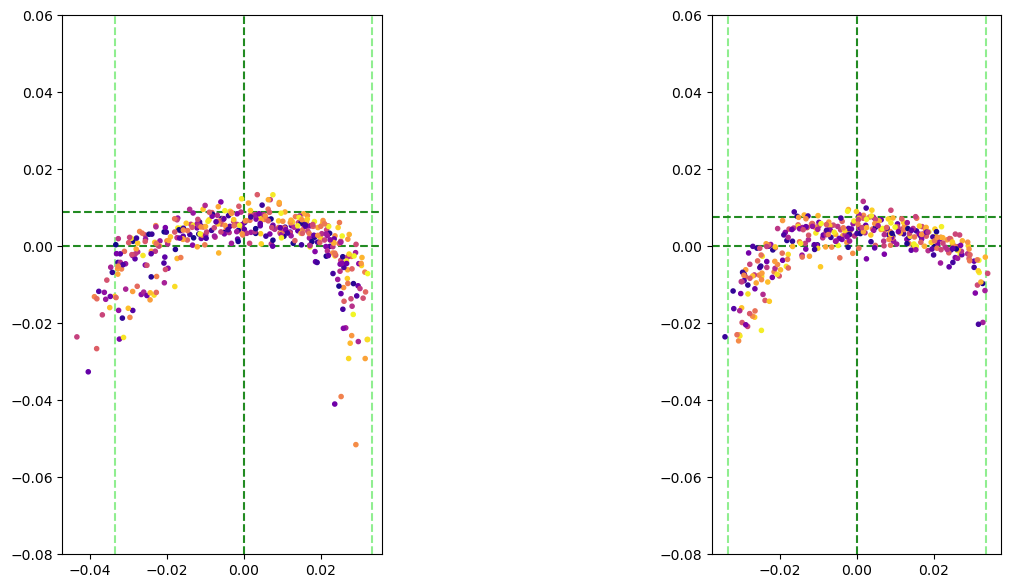

In [60]:
preset = "ObenNull1"
templatenr = 2

templatefile = templatefiles[templatenr]
print(templatefile)

cluster_this, cluster_other, cluster_pair = load_clusters(preset)
_, eigenvects = pca(cluster_this)
transformmatrix = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)
plot_cluster_pair(cluster_this, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster");

In [14]:
threshold = 0.02  # 0.2

In [61]:
cluster = cluster_other  # ####### cluster_this or cluster_other

_, eigenvects = pca(cluster)

clustercenter = cluster.mean(axis=0)

centered = cluster - clustercenter
centered_pcd = o3d.geometry.PointCloud()
centered_pcd.points = o3d.utility.Vector3dVector(centered)

trans_init = get_o3d_transform(eigenvects)

target = centered_pcd
source = template2 = o3d.io.read_point_cloud(os.path.join("templates", templatefile))

print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)


# Name of the cluster
try:
    test = np.all(cluster == cluster_this)
except ValueError:
    # Broadcast error wenn nicht gleicher shape
    test = False
if test:
    clustername = "this"
else:
    clustername = "other"
print(f"Cluster {clustername}")

#draw_registration_result(source, target, trans_init)

Evaluate initial alignment
RegistrationResult with fitness=5.757629e-01, inlier_rmse=1.218766e-02, and correspondence_set size of 6604
Access transformation to get result.
Cluster other


### Point to Point ICP

In [62]:
start = time.time()
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
print("Time taken: ", time.time() - start)
draw_registration_result(source, target, reg_p2p.transformation)
print(f"{preset}_t{templatenr}_point_{clustername}")

Apply point-to-point ICP
RegistrationResult with fitness=6.617262e-01, inlier_rmse=1.209382e-02, and correspondence_set size of 7590
Access transformation to get result.
Transformation is:
[[-0.99277166  0.11687554  0.02655013 -0.00115424]
 [-0.11689658 -0.99314369  0.00465931 -0.00206771]
 [ 0.02691265 -0.00239195  0.99963662  0.0090322 ]
 [ 0.          0.          0.          1.        ]]
Time taken:  0.24764704704284668
ObenNull1_t2_point_other


### Point to Plain ICP

In [63]:
start = time.time()
print("Apply point-to-plane ICP")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  

reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
draw_registration_result(source, target, reg_p2l.transformation)
print(f"{preset}_t{templatenr}_plane_{clustername}")

Apply point-to-plane ICP
nn distance 0.00700750067460067
RegistrationResult with fitness=5.590235e-01, inlier_rmse=1.173444e-02, and correspondence_set size of 6412
Access transformation to get result.
Transformation is:
[[-0.47983545  0.10482587  0.87065461  0.03478324]
 [-0.05658328 -0.99446721  0.09239874 -0.05195684]
 [ 0.87552324 -0.00681998  0.48313872 -0.01066742]
 [ 0.          0.          0.          1.        ]]
Time: 0.86708664894104
ObenNull1_t2_plane_other
